In [1]:
import numpy as np
from matplotlib import pyplot as plt
import glob
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from cycler import cycler
from scipy.stats import norm
import cv2
from sklearn.decomposition import PCA

from models.models import *
from models.modules import *
from visual_model_experiment import train
from HGMM import *
from model_builder import build_vis_model

In [2]:
lr = 0.001
epochs = 100
batch_size = 4
img_size = (128, 160)

preprocess = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])


monochrome = (cycler('color', ['k']) * cycler('marker', ['', '.', 'x']) *
              cycler('linestyle', ['-', '--', ':']))

plt.style.use('default')

In [3]:
############################################ DATA PREP / LOAD
def get_all_points(split, sets, d_map=False):
    out = {
        "gt": [],
        "input": [],
    }
    for mode in ["gt", "input"]:
        for sub in sets:
            path = rf"D:\Documents\mscProject\IJCAI_2021_Continual_Crowd_Counting_Challenge\full_data\{sub}\{split}\{mode}\*.{'csv' if mode == 'gt' else 'jpg'}"

            for f in glob.glob(path):
                if mode == "input":
                    image = Image.open(f)
                    image = preprocess(image)
                    out[mode].append(image)
                elif d_map:
                    point = np.genfromtxt(f, delimiter=',')
                    gt_size = point.shape
                    point = cv2.resize(point, (img_size[1], img_size[0]))
                    point = point * ((gt_size[0] * gt_size[1]) / (img_size[0] * img_size[1]))
                    out[mode].append(np.expand_dims(point, axis=0).flatten())
                else:
                    point = np.genfromtxt(f, delimiter=',')
                    point = np.sum(point)
                    out[mode].append(point)
        if not d_map:
            out["gt"] = torch.Tensor(out["gt"])
        else:
            out["gt"] = np.vstack(out["gt"])

    return out

In [5]:
train_data = get_all_points("train", ["mall", "fdst", "ucsd"])
test_data = get_all_points("val", ["mall"])

In [4]:
#train_data_m = get_all_points("train", ["mall", "fdst", "ucsd"], d_map=True)
train_data_m = get_all_points("train", ["mall"], d_map=True)
test_data_m = get_all_points("val", ["mall"], d_map=True)

In [6]:
weights = "saves/Resnet_18_count_train_ucsd_fdst_mall.pt"
model = build_vis_model("Resnet_18", density_map=False)
model.load_state_dict(torch.load(weights))

<All keys matched successfully>

In [5]:
weights = "saves/Unet_map_train_ucsd_fdst_mall.pt"
model_m = build_vis_model("Unet", density_map=True)
model_m.load_state_dict(torch.load(weights))

<All keys matched successfully>

In [7]:
model.eval()
features = []
train_features = []

with torch.no_grad():

    for img in test_data["input"]:
        features.append(torch.flatten(model.features(torch.unsqueeze(img, 0)), start_dim=1))
    features = torch.stack(features)

    for img in train_data["input"]:
        train_features.append(torch.flatten(model.features(torch.unsqueeze(img, 0)), start_dim=1))
    train_features = torch.stack(train_features)

In [8]:
pca = PCA(.99).fit(train_features.squeeze())

In [12]:
features_pca = pca.transform(features.squeeze())
train_features_pca = pca.transform(train_features.squeeze())

In [6]:
model_m.eval()
features_m = []
train_features_m = []

with torch.no_grad():

    for img in test_data_m["input"]:
        features_m.append(torch.flatten(model_m.features(torch.unsqueeze(img, 0)), start_dim=1))
    features_m = torch.stack(features_m)

    for img in train_data_m["input"]:
        train_features_m.append(torch.flatten(model_m.features(torch.unsqueeze(img, 0)), start_dim=1))
    train_features_m = torch.stack(train_features_m)

In [7]:
pca = PCA(256).fit(train_features_m.squeeze())
features_m_pca = pca.transform(features_m.squeeze())
train_features_m_pca = pca.transform(train_features_m.squeeze())
#seq = np.expand_dims(pca.transform(seq.squeeze()), 2)

In [28]:
inference_1 = []

with torch.no_grad():
    for img in test_data["input"]:
        inference_1.append(torch.flatten(model.forward(torch.unsqueeze(img, 0)), start_dim=1))
    inference_1 = torch.stack(inference_1)

In [ ]:
inference_2 = []

with torch.no_grad():
    for img in test_data_m["input"]:
        inference_1.append(torch.flatten(model.forward(torch.unsqueeze(img, 0)), start_dim=1))
    inference_1 = torch.stack(inference_1)

In [27]:
l_model = HGMM(1, 160)
l_model.supervised_seq(np.expand_dims(train_features_pca.squeeze(), axis=2), np.expand_dims(train_data["gt"].detach().numpy(), axis=1))

NameError: name 'train_features_pca' is not defined

In [8]:
l_model = HGMM(20480, 256)
l_model.supervised_seq(train_features_m_pca.astype(np.float32), train_data_m["gt"].astype(np.float32))


KeyboardInterrupt



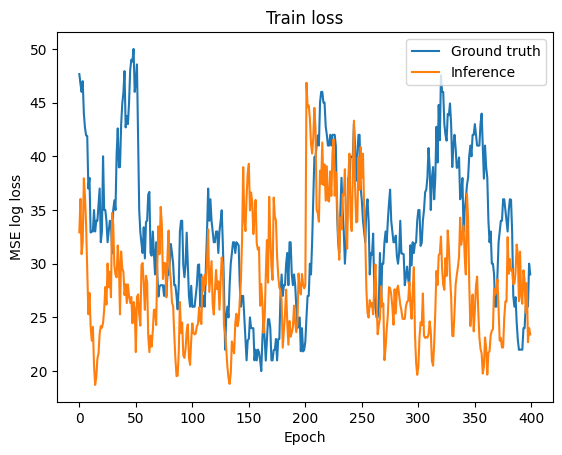

In [39]:
fig, ax = plt.subplots()

#ax.set_prop_cycle(monochrome)

ax.plot(test_data["gt"].detach().numpy(), label="Ground truth")
ax.plot(inference_1.squeeze(), label="Inference")



ax.set_title("Train loss")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE log loss")

#plt.savefig("imgs/count_general_train.png", dpi=300)
plt.show()

In [113]:
test = np.mean(abs(test_data["gt"].detach().numpy() - inference_1.detach().numpy().squeeze()))

In [32]:
seq_likelihood, mus, ps, hs = l_model.bw_forward(np.expand_dims(features_m_pca.squeeze()[:10], axis=2))
p_Ts, mu_Ts, p_prev_Ts = l_model.bw_backward(np.expand_dims(features_m_pca.squeeze()[:10], axis=2), mus, ps, hs)

MemoryError: Unable to allocate 31.2 GiB for an array with shape (10, 20480, 20480) and data type float64

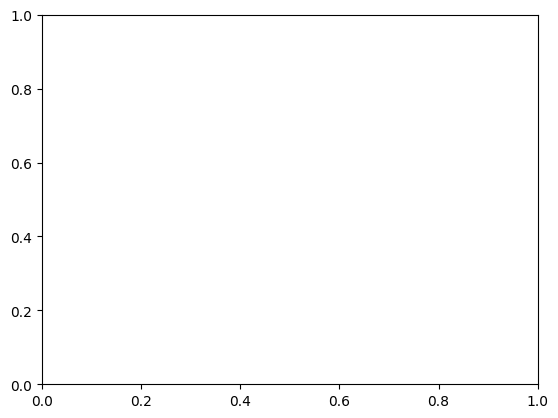

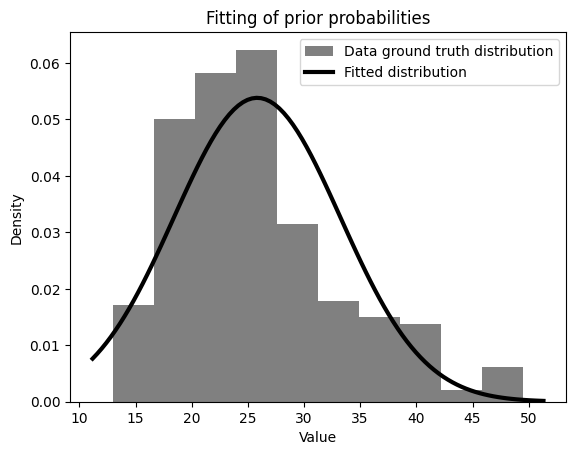

In [59]:
fig, ax = plt.subplots()

#train_data_lm = get_all_points("train", ["mall"])

mu, var = gauss_fit(np.expand_dims(train_data_lm["gt"].detach().numpy().squeeze(), axis=1))



fig, ax = plt.subplots()
ax.hist(train_data_lm["gt"].detach().numpy().squeeze(), density=True, color="grey", label="Data ground truth distribution")
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, np.sqrt(var))
ax.plot(x, p.squeeze(), label="Fitted distribution", lw=3, color='black')

ax.legend()
ax.set_title("Fitting of prior probabilities")
ax.set_xlabel("Value")
ax.set_ylabel("Density")
#plt.show()
plt.savefig("imgs/gauss_fit.png", dpi=300)


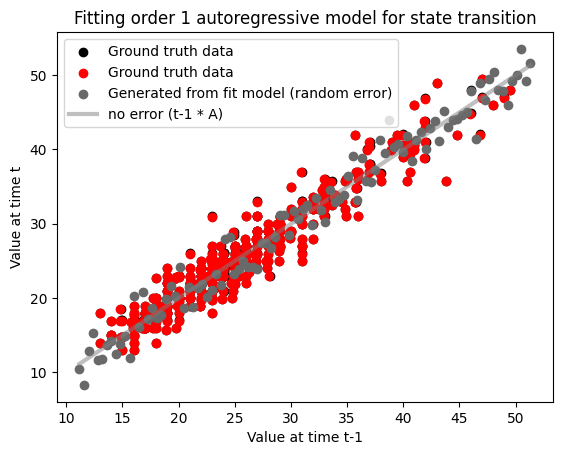

In [105]:
gt_data = np.expand_dims(train_data_lm["gt"].detach().numpy().squeeze(), axis=1)

a, q = auto_reg1_fit(gt_data)
model = AutoReg(gt_data, lags=1, trend='n').fit()
std = np.sqrt(q[0,0])

fig, ax = plt.subplots()

ax.scatter(gt_data[:-1], gt_data[1:], label="Ground truth data", color="black")
ax.scatter(model.fittedvalues[:-1], model.fittedvalues[1:], label="Ground truth data", color="red")
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = np.random.normal(0, std, 100)
gen = (a * x).squeeze()
ax.scatter(x, gen+p, label="Generated from fit model (random error)", color="dimgray")

y1 = gen - std
y2 = gen + std
ax.plot(x, gen, color="gray", linewidth=3, alpha=0.5, label="no error (t-1 * A)")
#ax.fill_between(x, y1, y2, alpha=.3, linewidth=0, color="red", label="+- 1 std in error")

ax.set_title("Fitting order 1 autoregressive model for state transition")
ax.legend(loc="upper left")
ax.set_xlabel("Value at time t-1")
ax.set_ylabel("Value at time t")

plt.savefig("imgs/autoreg_fit1.png", dpi=300)

In [77]:
inference_lm = []

with torch.no_grad():
    for img in train_data_lm["input"]:
        inference_lm.append(torch.flatten(model.features(torch.unsqueeze(img, 0)), start_dim=1))
    inference_lm = torch.stack(inference_lm)

In [14]:
#np.expand_dims(inference_lm.detach().numpy().squeeze(), axis=1)

In [78]:
b, r = linear_reg_fit(np.expand_dims(inference_lm.detach().numpy().squeeze(), axis=2), gt_data)
std = np.sqrt(r[0,0])

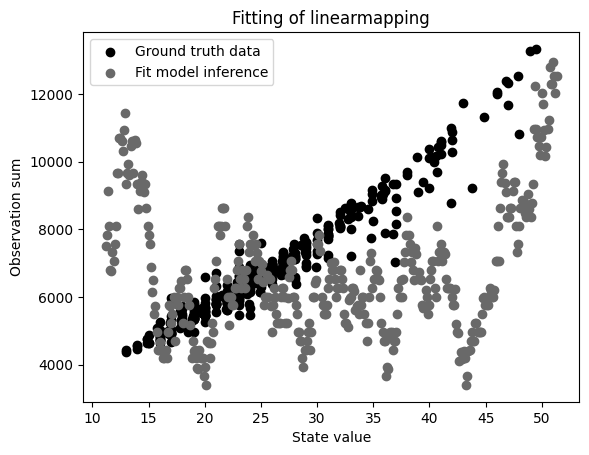

In [93]:
model_vis = LinearRegression(fit_intercept=False).fit(gt_data, np.squeeze(np.expand_dims(inference_lm.detach().numpy().squeeze(), axis=2)))
fig, ax = plt.subplots()
ax.scatter(gt_data, np.expand_dims(inference_lm.detach().numpy().squeeze(), axis=2).sum(axis=1), label="Ground truth data", color="black")
xmin, xmax = ax.get_xlim()
x = np.expand_dims(np.linspace(xmin, xmax, 400), axis=1)
#p = np.random.multivariate_normal(np.zeros((10240)), r, 100)
#gen = (b @ x.T).squeeze().T
gen = model_vis.predict(gt_data)
ax.scatter(x, (gen).sum(axis=1), label="Fit model inference", color="dimgray")
#ax.scatter(x, (gen+p).sum(axis=1), label="Generated from fit model (random error)", color="dimgray")
#ax.hist(diff)
#ax.scatter(diff)
# y1 = gen - std
# y2 = gen + std
# ax.plot(x, gen.sum(axis=1), color="red", linewidth=2, alpha=0.5, label="no error (B * y)")
#ax.fill_between(x, y1, y2, alpha=.3, linewidth=0, color="orange", label="+- 1 std in error")

ax.set_title("Fitting of linearmapping")
ax.legend()
ax.set_xlabel("State value")
ax.set_ylabel("Observation sum")
plt.show()
#plt.savefig("imgs/lin_fit2.png", dpi=300)


In [102]:
test = np.expand_dims(inference_lm.detach().numpy().squeeze(), axis=2)
model.score(gt_data, inference_lm.detach().numpy().squeeze())


-0.19739671986629112